In [5]:

import numpy as np
import pandas as pd
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


climate data

In [7]:
# station schema, to read in fixed width file
station_schema = pd.read_csv('./data/station_schema.csv')
station_specs = tuple(zip(station_schema.start, station_schema.end))

# read in fixed width station file with schema data
stations = pd.read_fwf('./data/station_ref.txt', colspecs=station_specs)

# filter stations to those in US
us_stations = stations[stations.CT == 'US']
usa_stations = [i for i in us_stations.USAF]

# weather data schema, to read in fixed width file
weather_schema = pd.read_csv('./data/gsod_schema.csv')

# column names for df
weather_schema.drop([3,4], inplace=True)
weather_schema.loc[2, 'column'] = 'DATE'
weather_schema.loc[0, 'column'] = 'STN'
weather_cols = [i for i in weather_schema.column]

# column widths for df
weather_schema['end'] = weather_schema.start + weather_schema.length
weather_schema.loc[2, 'end'] = 22
weather_specs = tuple(zip(weather_schema.start, weather_schema.end))

In [8]:
def df_specs(years, usa_stations, weather_specs, weather_cols):
    output = {}
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('./data'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)
        
        # filter weather data to US stations
        us_weather = df[df.STN.isin(usa_stations)]
        output.update({x:len(us_weather.STN.unique())})
    
    return output

# turn weather dates into date-time values
def make_date(x):
    x = str(x)
    y = x[:4] + '/' + x[4:6] + '/' + x[6:]
    return pd.to_datetime(y, yearfirst=True)

# filter to US stations and clean data
def save_us_data(years, usa_stations, weather_specs, weather_cols):
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('./data'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)

        # drop count and flag columns
        df.drop(['WBAN', 'Count (TEMP)', 'Count (DEWP)', 'Count (SLP)','Count (STP)',
                'Count (VISIB)','Count (WDSP)', 'Flag (MAX)', 'Flag (MIN)',  'Flag (PRCP)'],
                axis=1, inplace=True)
                
        # filter weather data to US stations
        df = df[df.STN.isin(usa_stations)]

        # convert to datetime object
        df.DATE = df.DATE.map(lambda x: make_date(x))

        # replace "9" values with nans in appropriate columns
        nine_thou = ['TEMP', 'DEWP', 'SLP', 'STP', 'MAX', 'MIN']
        nine_hun = ['VISIB', 'WDSP', 'MXSPD', 'GUST', 'SNDP']
        for i in nine_thou:
            df[i].replace(9999.9, np.nan, inplace=True)
        for i in nine_hun:
            df[i].replace(999.9, np.nan, inplace=True)
            df.PRCP.replace(99.99, np.nan, inplace=True)
            
        df.to_csv('./data'+str(x)+'.csv', index=False)

In [ ]:
years = [x for x in range(1975, 2019)]
save_us_data(years, usa_stations, weather_specs, weather_cols)

# list of US stations in each year
stations_list = []
for x in range(1976, 2019):
    df = pd.read_csv('./data/us_data/'+str(x)+'.csv')
    stations = [i for i in df.STN.unique()]
    stations_list.append(stations)

# US stations in the year 1975
df = pd.read_csv('./data/us_data/1975.csv')
stations_75 = [i for i in df.STN.unique()]

# US stations that are in all years
common_stations = []
for each in stations_75:
    if sum(x.count(each) for x in stations_list) == len(stations_list):
        common_stations.append(each)


# filter to common US stations and impute missing data
def clean_same_stations(years, common_stations):
    for x in years:
        df = pd.read_csv('./data/us_data/'+str(x)+'.csv')
        # filter to US stations
        df = df[df.STN.isin(common_stations)]
        
        # reset index
        df.reset_index(inplace=True)
        
        # drop bad variables
        df = df.drop(['STP', 'MXSPD', 'GUST', 'SNDP'], axis=1)

        # separate discrete variables
        disc_vars = df[['PRCP', 'Fog', 'Rain/Drizzle', 'Snow/Ice pellets', 'Hail', 'Thunder','Tornado/Funnel cloud']]

        # interpolate continuous variables
        df = df[['STN', 'DATE','TEMP', 'DEWP', 'SLP', 'VISIB', 'WDSP', 'MAX', 'MIN']]
        df.interpolate(inplace=True)

        # rejoin data
        df = df.join(disc_vars)

        # Mice impute discrete variables
        dates = df['DATE']
        df.drop('DATE', axis=1, inplace = True)
        mice = MICE(verbose=False)
        df = pd.DataFrame(mice.complete(df), columns=[df.columns])
        df = df.join(dates)
        
        df.to_csv('./data/us_common_data/'+str(x)+'.csv', index=False)

commodities

In [45]:
corn = pd.read_csv('./data/corn-price-data.csv', names=['date', 'price'], header=0)
corn['date'] = pd.to_datetime(corn.date)

/tmp/ipykernel_5380/1335090394.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  corn['date'] = pd.to_datetime(corn.date)


In [46]:
def recession(x):
    if x > pd.Timestamp(1975,1,1) and x < pd.Timestamp(1975,3,31):
        return 1
    if x > pd.Timestamp(1979,3,31) and x < pd.Timestamp(1980,6,30):
        return 1
    if x > pd.Timestamp(1981,3,31) and x < pd.Timestamp(1982,6,30):
        return 1
    if x > pd.Timestamp(1989,9,30) and x < pd.Timestamp(1991,3,31):
        return 1
    if x > pd.Timestamp(2001,1,1) and x < pd.Timestamp(2001,9,30):
        return 1
    if x > pd.Timestamp(2007,9,30) and x < pd.Timestamp(2009,6,3):
        return 1
    else:
        return 0 
    
corn['recession'] = corn.date.map(lambda x: recession(x))

In [47]:
corn.head()

,date,price,recession
0,2069-06-02,1.3300,0
1,2069-06-03,1.3450,0
2,2069-06-04,1.3475,0
3,2069-06-05,1.3450,0
4,2069-06-06,1.3400,0


Text(0.5, 1.0, 'Historical Corn Prices')

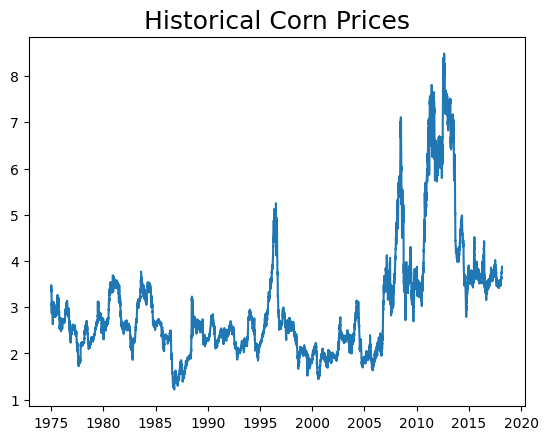

In [49]:
corn = corn[ corn.date > pd.Timestamp(1974,12,31) ]
corn = corn[ corn.date < pd.Timestamp(2018,12,31) ]
plt.plot(corn.date, corn.price)

plt.title('Historical Corn Prices', fontsize=18)
# plt.xlabel('Year', fontsize=22)
# plt.ylabel('Price', fontsize=22)
# plt.tick_params(labelsize=16)

In [53]:
main_df = pd.read_csv('./data/main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
final_df = pd.merge(corn, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']
main_df.head()

,DATE,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
0,1975-01-01,26.798754,0.486339,0.000000,44.633060,27.100638,0.096371,0.329690,1020.603498,0.273224,35.227322,0.003643,0.0,13.658761,8.176321
1,1975-01-02,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384
2,1975-01-03,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220
3,1975-01-04,24.331663,0.250890,0.001779,42.036744,24.544929,0.097979,0.274021,1018.656830,0.231317,32.974911,0.001779,0.0,14.807192,7.388256
4,1975-01-05,22.518032,0.192446,0.000000,42.088309,22.215063,0.056188,0.089928,1019.560352,0.201439,31.966187,0.000000,0.0,15.439308,7.246763


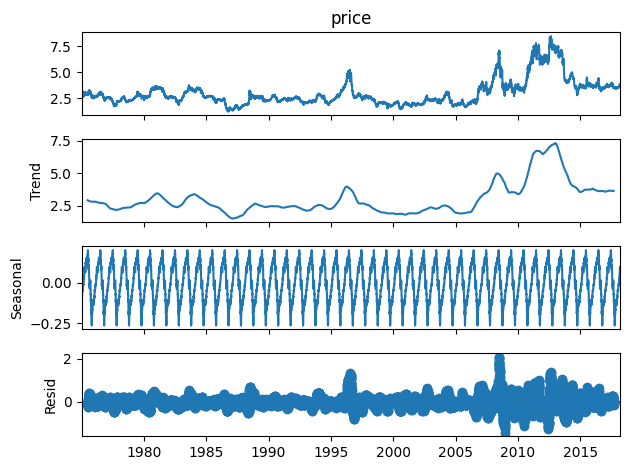

In [55]:
decomposition = seasonal_decompose(final_df.price, period=252)
decomposition.plot();

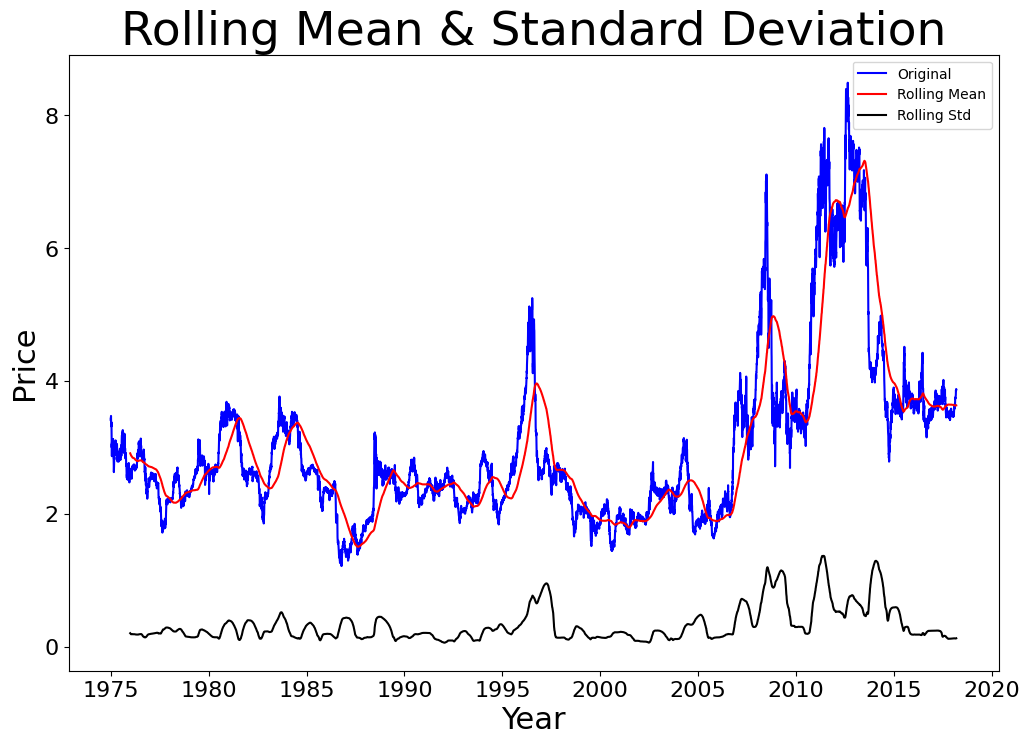

Results of Dickey-Fuller Test:
Test Statistic   -2.801737
p-value           0.058026
dtype: float64


In [56]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=252, center=False).mean()
    rolstd = timeseries.rolling(window=252, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=34)
    plt.xlabel('Year', fontsize=22)
    plt.ylabel('Price', fontsize=22)
    plt.tick_params(labelsize=16);
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)
    
test_stationarity(final_df.price)

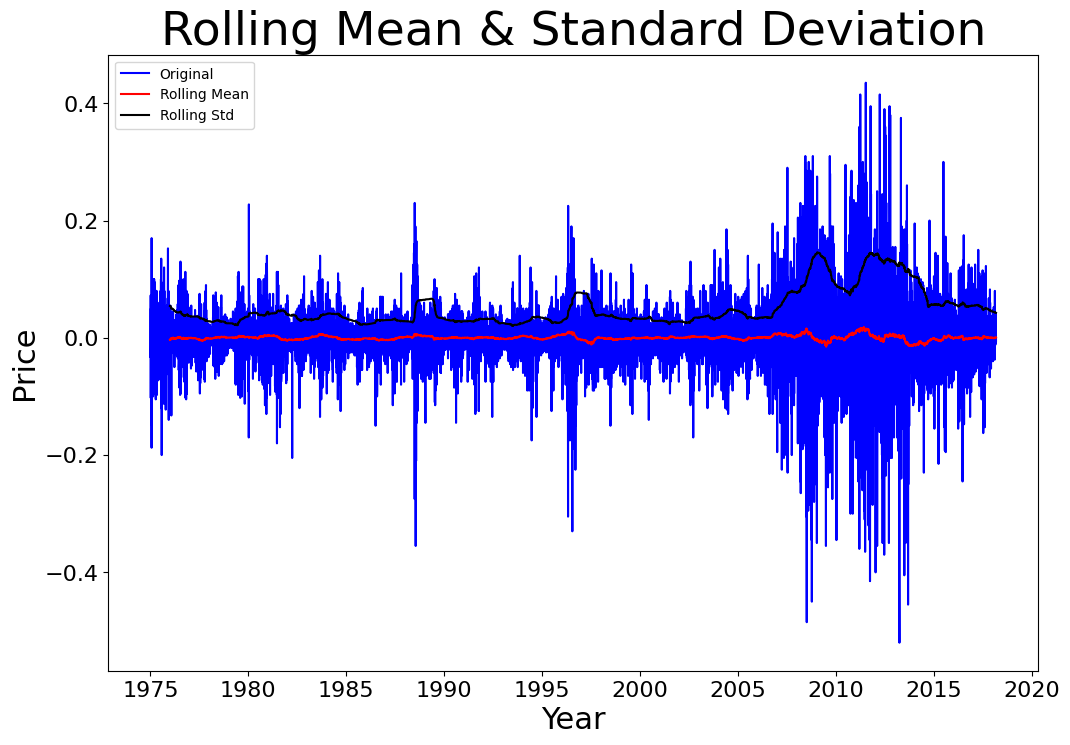

Results of Dickey-Fuller Test:
Test Statistic   -1.469466e+01
p-value           3.011577e-27
dtype: float64


In [57]:
# first difference
final_df['first_diff'] = final_df.price.diff()

# D-F test on first diff column
test_stationarity(final_df.first_diff.dropna())

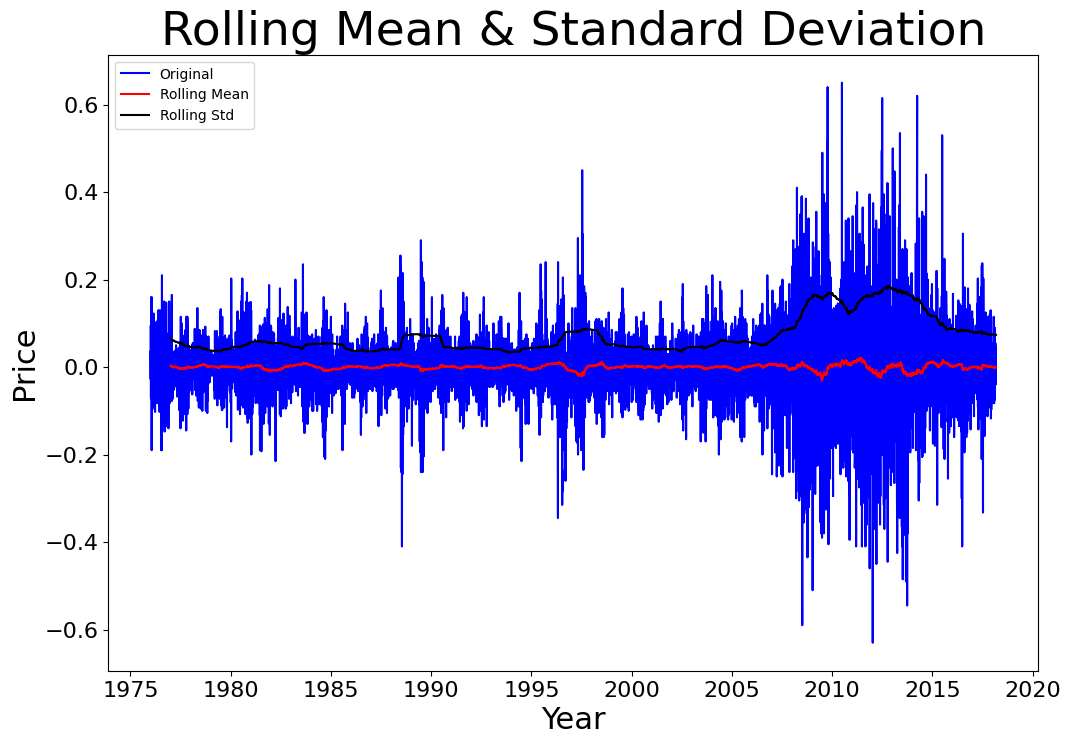

Results of Dickey-Fuller Test:
Test Statistic   -1.451608e+01
p-value           5.622084e-27
dtype: float64


In [58]:
# seasonal + first difference
final_df['seasonal_first_diff'] = final_df.price.diff().diff(252)

# D-F test
test_stationarity(final_df.seasonal_first_diff.dropna())

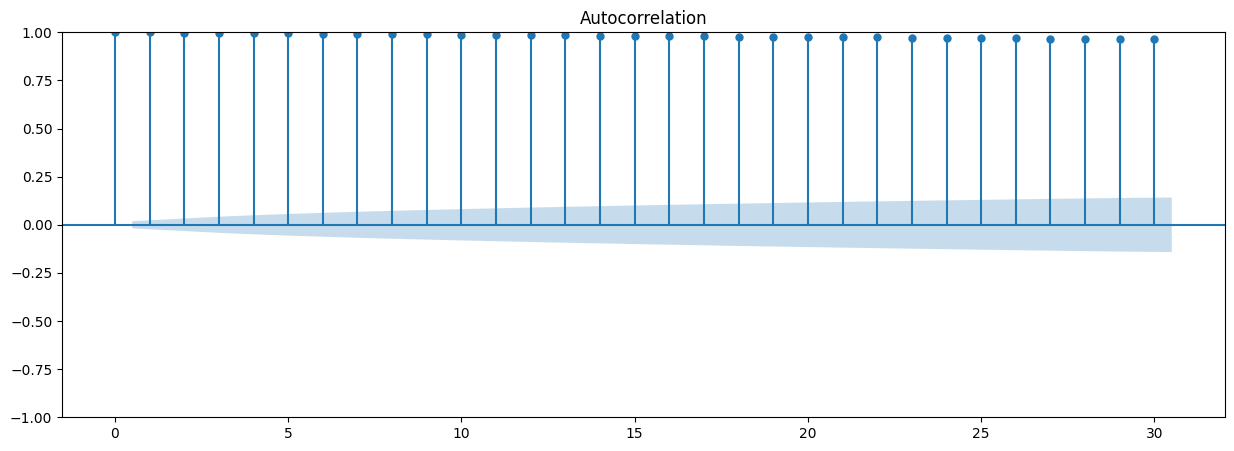

In [59]:
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(final_df.price, lags=30, ax=ax);

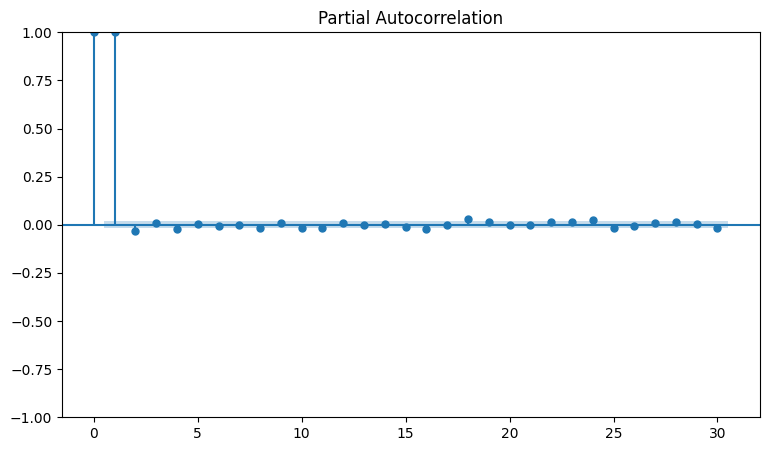

In [60]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(final_df.price, lags=30, ax=ax);

In [61]:
def model_eval(comm, results, final_df):
    # plot residuals
    plt.plot(results.resid[5:])
    plt.title(f'{comm} Price Residuals', fontsize=20)
    plt.xlabel('Year', fontsize=14)
    plt.show()

    # list of 15 day forecasts
    x = 9001      
    forward_15 = []
    for i in range(len(final_df) - 9015):
        pred = results.predict(start=x, end=x+14, dynamic=True)
        forward_15.append(pred[14])
        x += 1

    # 15 day preds vs actual
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(final_df.index[9015:], final_df.price[9015:], lw=2, color='grey', ls='dashed',label='Actual')
    ax.plot(final_df.index[9015:], forward_15, lw=2, color='darkred',label='Pred')
    plt.title(f'{comm} Fifteen Day Predictions vs Actual', fontsize=30)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price', fontsize=18)
    plt.tick_params(labelsize=12);
    plt.legend()
    plt.show()
    
    # 15 day r2 score
    print('15-day forecast r2 score:', r2_score(final_df.price[9015:], forward_15))

In [64]:
# corn model
main_df = pd.read_csv('./data/main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
final_df = pd.merge(corn, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']


p = 1 # number of lagged values
d = 1 # number of diffs in lag
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days in season

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model_eval('Corn', results, final_df)